In [ ]:
!pip install -q umap-learn openl3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.4/323.4 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import librosa as lr
import os
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from umap import UMAP
import matplotlib.pyplot as plt
import openl3
plt.rcParams['figure.dpi'] = 300

In [ ]:
#@title Mount Google Drive / Assign Directories
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
FILE = '/content/drive/MyDrive/tufo.opus' #@param

In [ ]:
y, sr = lr.load(FILE)
timestamps = np.array([0, 3*60+30, 7*60+15, 10*60+45, 13*60, 14*60+45,
                       17*60+50, 18*60+40, 20*60+30, 23*60+15,
                       24*60+40, 25*60+31, 27*60, 28*60, 32*60, 33*60+40,
                       36*60+20, 38*60+11, 39*60+5, 39*60+55, 40*60+45,
                       41*60+50, 44*60+10, 45*60+5, 46*60+30, 49*60,
                       51*60+44, 52*60+15, 55*60+47, 56*60, 57*60+30])

In [ ]:
tracks = ['0:00 Fred again.. - Danielle (Smile On My Face)',
'3:30 Taylor Swift - Love Story (KH Edit)',
'7:15 Roddy Ricch - The Box (Skrillex Edit)',
'10:45 Fred again.. - Bleu (Better With Time) ',
'13:00 Dog Blood - Want Some More',
'14:45 Skrillex & Starrah & Four Tet - Butterflies ',
'17:50 Romy & Fred again.. - Enjoy Your Life',
'18:40 Anna Lunoe ft. Genesis Owusu - Back Seat (Chris Lorenzo Remix) ',
'20:30 Skrillex ft. Bobby Raps - Leave Me Like This ',
'23:15 Joy Anonymous - JOY (Head To The Sky) ',
'24:40 PinkPantheress - Just For Me (salute Edit) ',
'25:31 J Balvin & Skrillex - In Da Getto (Chris Lorenzo Remix) ',
'27:00 J Balvin & Skrillex - In Da Getto (Andrew Lux Remix) ',
'28:00 Fred again.. & Skrillex & Four Tet ft. Lil Baby - Baby Again..  ',
'32:00 Hamdi - Skanka ',
'33:40 Skrillex & Fred again.. & Flowdan - Rumble ',
'36:20 Mizormac - Return of The Mac (ThatOneDJGuy Edit - Soundcloud)',
'38:11 HOL! - Country Riddim ',
'39:05 Jack Ü ft. Justin Bieber - Where Are Ü Now (Marshmello Remix / Skrillex Flip) ',
'39:55 Skrillex ft. Nai Barghouti - XENA ',
'40:45 Skrillex & Kito ft. Aluna - Inhale Exhale ',
'41:50 Fred again.. - Jungle  ATLANTIC (WARNER MUSIC)',
'44:10 EPROM & G Jones - On My Mind (RamonPang Flip) ',
'45:05 Skrillex ft. Starrah - Good Space ',
'46:30 Skrillex & Swae Lee & Siiickbrain & Posij - Too Bizarre (Juked)  ',
'49:00 Fred again.. - Delilah (Pull Me Out Of This)  ',
'51:44 Fred again.. - Billie (Loving Arms)  ',
'52:15 Skrillex & Mr. Oizo ft. Missy Elliott - RATATA ',
'55:47 Drake - Massive',
'56:00 JAY-Z ft. Alicia Keys - Empire State Of Mind (Acappella) ',
'57:30 Skrillex & Mr. Oizo ft. Missy Elliott - RATATA']

In [ ]:
def get_track_labels(t, timestamps):
  return len(timestamps[timestamps<=t])


def get_ssm_from_embs(embs, track_labels):
  ssm = pairwise_distances(embs)
  ssm = (ssm - float(np.min(ssm))) / (float(np.max(ssm)) - float(np.min(ssm)))
  for i in range(ssm.shape[0]):
    for j in range(i, ssm.shape[1]):
      if (abs(track_labels[i] - track_labels[j]) > 1):
        ssm[i][j] = 0
        ssm[j][i] = 0
  return ssm


def get_mfccs(y, sr, timestamps):
  hop_length = sr
  n_fft = int(2 ** np.ceil(np.log2(sr)))
  mfccs = lr.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_fft=n_fft).T
  times = lr.frames_to_time(np.arange(mfccs.shape[0]), sr=sr, hop_length=hop_length)
  track_labels = np.array([get_track_labels(t, timestamps) for t in times])
  return times, mfccs, track_labels


def get_openl3(y, sr, timestamps):
  hop_size = 1
  embedding_size = 512
  openl3_path = '/content/drive/MyDrive/openl3.npy'
  if os.path.isfile(openl3_path):
    openl3 = np.load(openl3_path)
  else:
    openl3, _ = openl3.core.get_audio_embedding(y, sr, hop_size=hop_size, embedding_size=embedding_size)
  times = lr.frames_to_time(np.arange(openl3.shape[0]), sr=sr, hop_length=hop_size*sr)
  track_labels = np.array([get_track_labels(t, timestamps) for t in times])
  return times, openl3, track_labels


def plot_ssm(times, embs, track_labels, timestamps):
  ssm = get_ssm_from_embs(embs, track_labels)

  plt.matshow(ssm, cmap='Greys')
  plt.xticks(timestamps, ['']*len(timestamps))
  plt.yticks(timestamps, ['']*len(timestamps))

  for i in range(1, len(timestamps)):
    min_val = timestamps[i-1]
    max_val = timestamps[i+1] if i < len(timestamps)-1 else times[-1]
    plt.hlines(timestamps[i], min_val, max_val, linewidths=0.5, linestyles='dotted')
    plt.vlines(timestamps[i], min_val, max_val, linewidths=0.5, linestyles='dotted')

  plt.colorbar()
  plt.show()


def emb_viz(embs, track_labels):
  N = track_labels[-1]
  for i in range(1, N):
    # include label i and i+1
    st = np.where(track_labels==i)[0][0]
    bo = np.where(track_labels==i+1)[0][0]
    en = np.where(track_labels==i+1)[0][-1]+1
    colors = np.linspace(0,1,en-st)
    s = np.ones(en-st) * (plt.rcParams['lines.markersize'] ** 2)
    s[0] = s[0]*3
    s[-1] = s[-1]*3
    data = UMAP(n_components=3).fit_transform(embs[st:en])
    print(f'from track_label {i}: {tracks[i-1]} to track_label {i+1}: {tracks[i]}')
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    cm = plt.cm.autumn # autumn is from red to yellow
    ax.scatter(data[:bo-st,0], data[:bo-st,1], data[:bo-st,2], marker='o', c=cm(colors[:bo-st]), s=s[:bo-st])
    ax.scatter(data[bo-st:,0], data[bo-st:,1], data[bo-st:,2], marker='+', c=cm(colors[bo-st:]), s=s[bo-st:])
    plt.show()

In [ ]:
#@title Functions to calculate smoothness heuristic for each transition, and ordering

def calculate_smoothness(embs, track_labels):

  NO_INCREASE_LIMIT = 15
  TRANSITION_LENGTH_LIMIT = 0.5 #percentage
  N = track_labels[-1] # number of tracks
  N_transitions = N-1
  transition_starts = np.zeros(N_transitions)
  transition_ends = np.zeros(N_transitions)
  transition_lengths = np.zeros(N_transitions)

  # loop over each pair of tracks
  for i in range(1,N):
    print("Transition:", i)
    st = np.where(track_labels==i)[0][0]
    bo = np.where(track_labels==i+1)[0][0]
    en = np.where(track_labels==i+1)[0][-1]+1

    data = embs[st:en]

    transition_point_vector = data[bo-st]

    #print(np.size(data))
    print(f'from track {tracks[i-1]} to track {tracks[i]}:')
    #print(data[bo-st]) ## This is the transition marker

    ## After
    no_increase_for = 0
    distance_from_transition = 0
    greatest_distance = 0

    # This is how far away fro the transition you should check before stopping e.g. 50% of the length
    distance_from_transition_to_track2_end = en-bo
    bo_2_en_limit = round(TRANSITION_LENGTH_LIMIT * distance_from_transition_to_track2_end)

    # This is how far away fro the transition you should check before stopping e.g. 50% of the length
    distance_from_transition_to_track1_beg = bo-st
    bo_2_st_limit = round(TRANSITION_LENGTH_LIMIT * distance_from_transition_to_track1_beg)


    while (no_increase_for < NO_INCREASE_LIMIT and bo_2_en_limit > distance_from_transition):

      # Euclidian distance
      #distance = np.linalg.norm(data[bo-st + distance_from_transition] - data[bo-st + distance_from_transition + 1])
      distance = np.linalg.norm(transition_point_vector - data[bo-st + distance_from_transition + 1])

      # Check if the distance has increased / remained the same
      if distance >= greatest_distance:
        no_increase_for = 0
        greatest_distance = distance
      else:
        no_increase_for +=1

      distance_from_transition += 1

    #if (distance_from_transition < bo_2_en_distance or no_increase_for >= NO_INCREASE_LIMIT):
    if (no_increase_for >= NO_INCREASE_LIMIT):
      dist_1 = distance_from_transition - NO_INCREASE_LIMIT
    else:
      dist_1 = distance_from_transition


    ## Before
    no_increase_for = 0
    distance_from_transition = 0
    greatest_distance = 0

    while (no_increase_for < NO_INCREASE_LIMIT and bo_2_st_limit > distance_from_transition):

      # Euclidian distance
      distance = np.linalg.norm(transition_point_vector - data[bo-st - distance_from_transition - 1])

      # Check if the distance has increased / remained the same
      if distance >= greatest_distance:
        no_increase_for = 0
        greatest_distance = distance
      else:
        no_increase_for +=1

      distance_from_transition += 1

    if (no_increase_for >= NO_INCREASE_LIMIT):
      dist_2 = distance_from_transition - NO_INCREASE_LIMIT
    else:
      dist_2 = distance_from_transition

    transition_length = dist_1 + dist_2 + 1

    print("Transition Length: ", transition_length)
    print("Distance before Transition point: ", dist_2)
    print("Distance after Transition point: ", dist_1)
    transition_starts[i-1] = dist_2
    transition_ends[i-1] = dist_1
    transition_lengths[i-1] = transition_length

  return transition_starts, transition_ends, transition_lengths

def order_by_transition_length(transition_length):

  # Get the indices ordered by values
  return np.argsort(transition_length)

In [ ]:
times, embs, track_labels = get_mfccs(y, sr, timestamps)

In [ ]:
#@title Calculate Smoothness for MFCC

transition_starts, transition_ends, transition_lengths = calculate_smoothness(embs, track_labels)

Transition: 1
from track 0:00 Fred again.. - Danielle (Smile On My Face) to track 3:30 Taylor Swift - Love Story (KH Edit):
Transition Length:  53
Distance before Transition point:  11
Distance after Transition point:  41
Transition: 2
from track 3:30 Taylor Swift - Love Story (KH Edit) to track 7:15 Roddy Ricch - The Box (Skrillex Edit):
Transition Length:  62
Distance before Transition point:  36
Distance after Transition point:  25
Transition: 3
from track 7:15 Roddy Ricch - The Box (Skrillex Edit) to track 10:45 Fred again.. - Bleu (Better With Time) :
Transition Length:  62
Distance before Transition point:  33
Distance after Transition point:  28
Transition: 4
from track 10:45 Fred again.. - Bleu (Better With Time)  to track 13:00 Dog Blood - Want Some More:
Transition Length:  93
Distance before Transition point:  40
Distance after Transition point:  52
Transition: 5
from track 13:00 Dog Blood - Want Some More to track 14:45 Skrillex & Starrah & Four Tet - Butterflies :
Transiti

In [ ]:
#@title Order Transitions by Normalised Smoothness

# Normalization #2
relative_smoothness = (transition_lengths - np.min(transition_lengths)) / (np.max(transition_lengths) - np.min(transition_lengths))

# Reorder values_array based on order_indices
values_array = relative_smoothness
order_indices = order_by_transition_length(transition_lengths)
ordered_values = values_array[order_indices]

# Stack arrays horizontally to print as table
stacked_array = np.column_stack(((order_by_transition_length(transition_lengths) +1), ordered_values))

# Print the table
print("Transition | Relative Smoothness")
print("---------------------------------")
for row in stacked_array:
    print(f"{row[0]:^7} | {row[1]:^7}")

Transition | Relative Smoothness
---------------------------------
 18.0   |   0.0  
 29.0   | 0.05813953488372093
 20.0   | 0.06976744186046512
 11.0   | 0.10465116279069768
  7.0   | 0.13953488372093023
 14.0   | 0.1511627906976744
 28.0   | 0.22093023255813954
 26.0   | 0.23255813953488372
 19.0   | 0.26744186046511625
 27.0   | 0.3372093023255814
 25.0   | 0.4186046511627907
 12.0   | 0.4418604651162791
  9.0   | 0.45348837209302323
 10.0   | 0.46511627906976744
 24.0   | 0.46511627906976744
  8.0   | 0.47674418604651164
 22.0   |   0.5  
  1.0   | 0.5348837209302325
 15.0   | 0.5348837209302325
 16.0   | 0.5348837209302325
  5.0   | 0.5348837209302325
 23.0   | 0.5465116279069767
 13.0   | 0.5813953488372093
 21.0   | 0.6046511627906976
 30.0   | 0.6046511627906976
  3.0   | 0.6395348837209303
  2.0   | 0.6395348837209303
 17.0   | 0.686046511627907
  6.0   | 0.7790697674418605
  4.0   |   1.0  


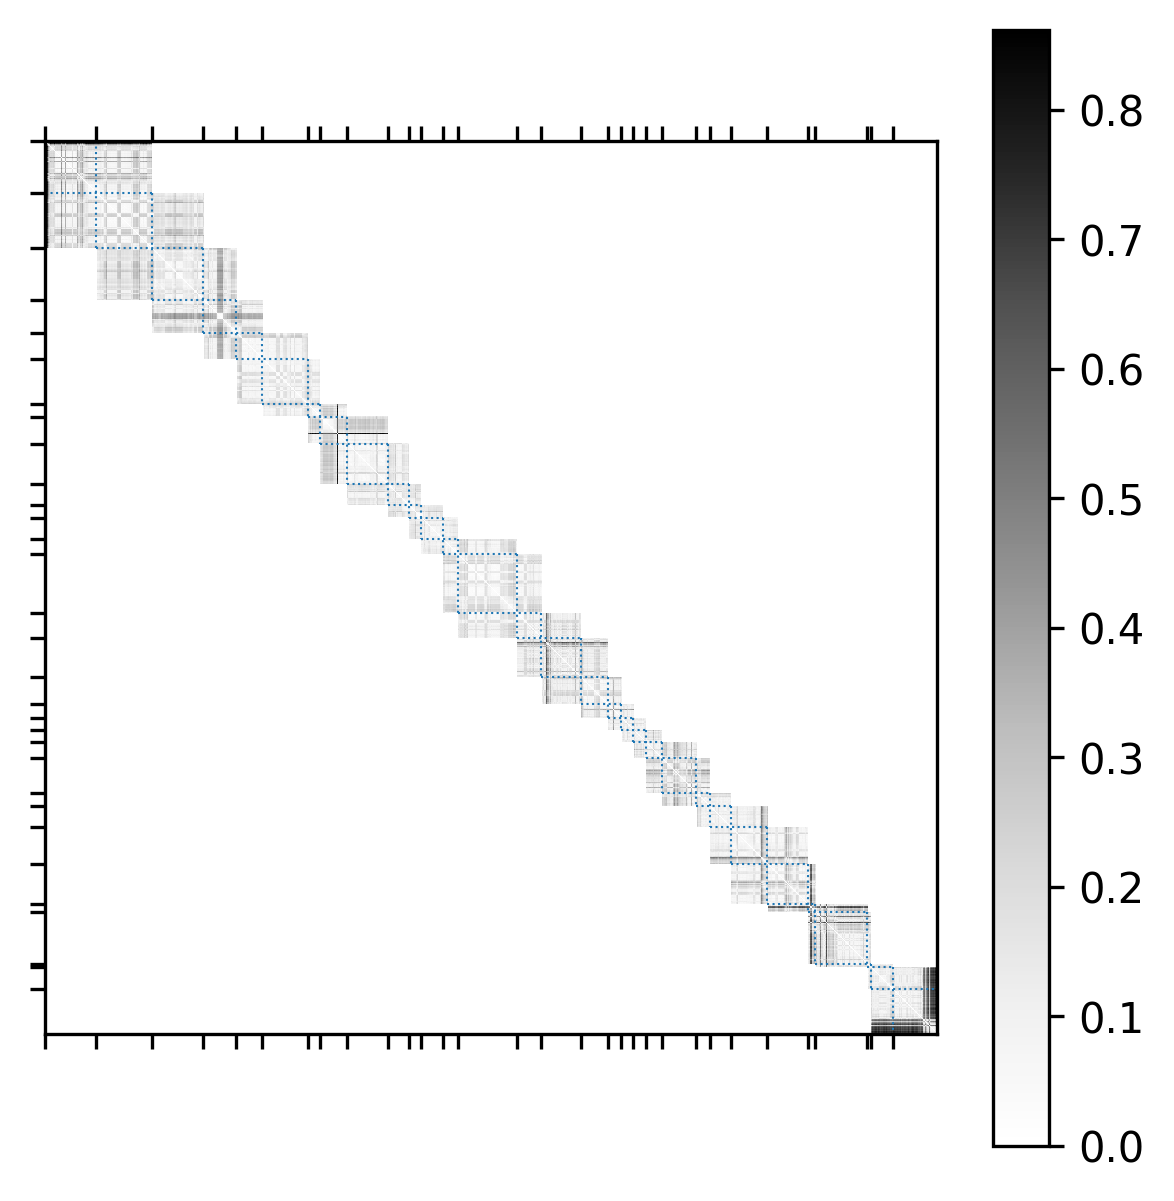

In [ ]:
plot_ssm(times, embs, track_labels, timestamps)

In [ ]:
emb_viz(embs, track_labels)

In [ ]:
times, embs, track_labels = get_openl3(y, sr, timestamps)

In [ ]:
#@title Calculate Smoothness for OpenL3

transition_starts, transition_ends, transition_lengths = calculate_smoothness(embs, track_labels)

In [ ]:
#@title Order Transitions by Normalised Smoothness

# Normalization #2
relative_smoothness = (transition_lengths - np.min(transition_lengths)) / (np.max(transition_lengths) - np.min(transition_lengths))

# Reorder values_array based on order_indices
values_array = relative_smoothness
order_indices = order_by_transition_length(transition_lengths)
ordered_values = values_array[order_indices]

# Stack arrays horizontally to print as table
stacked_array = np.column_stack(((order_by_transition_length(transition_lengths) +1), ordered_values))

# Print the table
print("Transition | Relative Smoothness")
print("---------------------------------")
for row in stacked_array:
    print(f"{row[0]:^7} | {row[1]:^7}")

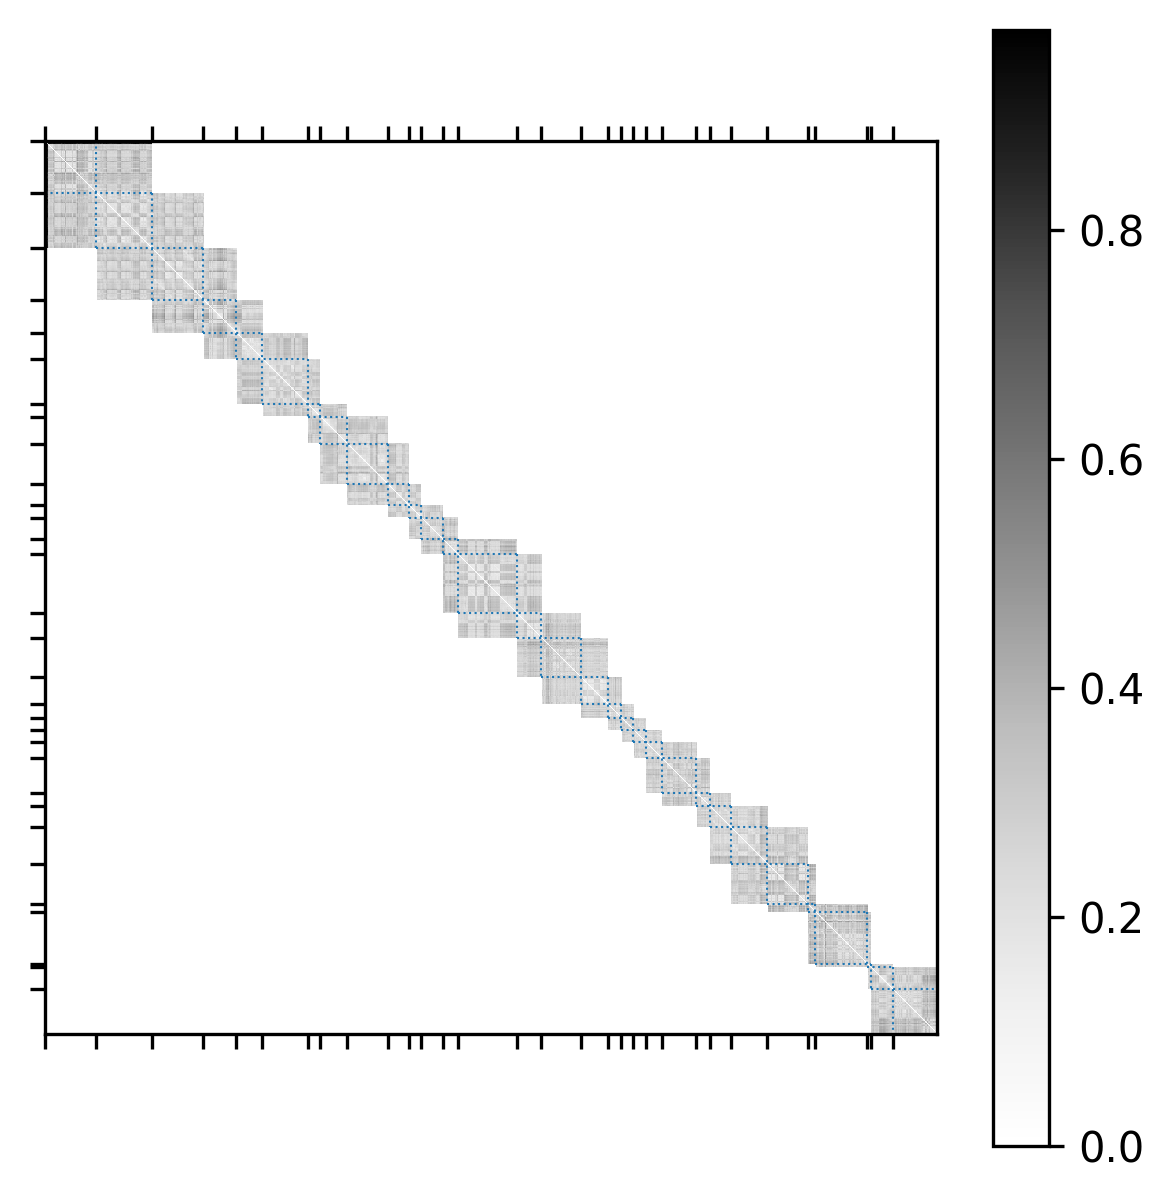

In [ ]:
plot_ssm(times, embs, track_labels, timestamps)

In [ ]:
emb_viz(embs, track_labels)